In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import xlrd
import operator
import math
import re
import nltk
import scipy
import openpyxl
from collections import Counter
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [12]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
# Uitschieters weghalen.
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...


# Data Info

498.18961004094234 386.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


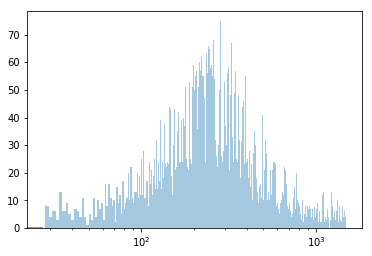

In [22]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
f=scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


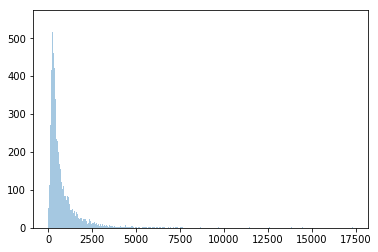

In [15]:
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
plt.savefig("Verslag/Tables/lengthtexts.png")

In [17]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(f[0]+2*f[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(f[0]-2*f[1])]
print(math.exp(f[0]+2*f[1]),math.exp(f[0]-2*f[1]))
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("mediaan",np.median([len(doc) for doc in list_text]),"gemiddelde",np.mean([len(doc) for doc in list_text]))
print("overgebleven documenten:"len(df))

1492.675589876518 27.339307082607387
386.0 498.18961004094234
14899


In [23]:
len(df.file.unique())

2984

In [37]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string
# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


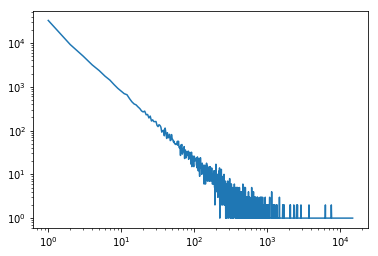

In [19]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [20]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.14      0.14      0.14      1901
ChristenUnie       0.06      0.07      0.06      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.07      0.06      0.07      1068
         PVV       0.12      0.11      0.12      1700
        PvdA       0.11      0.12      0.11      1821
        PvdD       0.02      0.02      0.02       432
         SGP       0.06      0.05      0.05       655
          SP       0.15      0.15      0.15      2284
         VVD       0.11      0.11      0.11      1694

 avg / total       0.11      0.11      0.11     14899



In [21]:
accuracy_score(df.party, np.full(len(df.party), countdf.idxmax()))

0.15329887911940399

# Models

In [ ]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [ ]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [ ]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=5)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [ ]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')
print(pipe.steps)

In [ ]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))
print('Accuracy: ', accuracy_score(df_test.party, predicted))

In [ ]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

In [ ]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [ ]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [ ]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
df.head(5)

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

In [ ]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

In [ ]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Regering & Oppositie

In [ ]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.PartijStatus)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.PartijStatus, predicted))

In [ ]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

In [ ]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

# Woorden Balkenende 4

In [ ]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4.head(5)

In [ ]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

In [ ]:
Party_synomyns
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
dfb4['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
dfb4.head(5)

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
dfb4_train = dfb4.sample(frac=0.8)
dfb4_test_index = list(set(dfb4.index.tolist()) - set(dfb4_train.index.tolist()))
dfb4_test = dfb4[dfb4.index.isin(dfb4_test_index)]
pipe.fit(list(dfb4_train.withoutnames), list(dfb4_train.party))
predicted = pipe.predict(dfb4_test.withoutnames)
print(classification_report(dfb4_test.party, predicted))

In [ ]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

In [ ]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dfb4_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(dfb4.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Vergelijken

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(tempdf.withoutnames, tempdf.party)
predicted = pipe.predict(dfb4.withoutnames)
print(classification_report(dfb4.party, predicted))

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(dfb4.withoutnames, dfb4.party)
predicted = pipe.predict(tempdf.withoutnames)
print(classification_report(tempdf.party, predicted))

# Links / Rechts vergelijken

In [ ]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

# Git

In [38]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push

Already up to date.


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=8>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  return process_handler(cmd, _system_body)


[master f80c78c] Update
 1 file changed, 17 insertions(+), 15 deletions(-)
 rewrite Verslag/Tables/Spreekbeurten.tex (88%)


To https://github.com/jaspervdh96/Scriptie-Sprekers-TK.git
   1315f02..f80c78c  master -> master
